In [1]:
%config IPCompleter.greedy=True #si puo' cancellare, è per avere l'autocompletion su jupyter notebook ma non pare funzionare

import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import csv
from utils import *
from models import *
device = "cuda" if torch.cuda.is_available() else "cpu"
writer = SummaryWriter('runs/experiment_name',flush_secs=5)

class PointsDataset(Dataset):
    def __init__(self, root_dir, transform=None, padding=None):
        """
        Args:
            root_dir (str): Root directory containing subfolders, each representing a sample.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.sim_info = []

        try:
            with open(os.path.join(self.root_dir, "Simulations_Info.csv"), newline='') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    index = int(row["INDEX"])
                    completed = row["COMPLETED"].strip().lower() in ["true", "1", "yes"]
                    self.sim_info.append((index, completed))
        except:
            self.sim_info = [(i, True) for i in range(5001)]
        #import pdb;pdb.set_trace()
        # Iterate over each subfolder in root_dir and load all data
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            sample_idx = [int(s) for s in re.findall(r'\d+', subfolder)]  # Extract the first number in the subfolder name
            if sample_idx:
                sample_idx = sample_idx[0]
            else:
                continue
           
            completed = next((item[1] for item in self.sim_info if item[0] == sample_idx), None) #completed refers to abaqus simulation stsatus
            if os.path.isdir(subfolder_path) and sample_idx and completed:
                init_coords_circle_file = next((f for f in os.listdir(subfolder_path) if f.endswith('input_coordinates_bullet_1.csv')), None)
                before_coords_file = next((f for f in os.listdir(subfolder_path) if f.endswith('input_coordinates_bullet_2.csv')), None)
                gt_file = next((f for f in os.listdir(subfolder_path) if f.endswith('output_displacement_external.csv')), None)
                init_coord_plate_file = os.path.join(root_dir,'../plate_initial_coordinates.csv')
                # Load ground truth data (displacement external)
                init_coord_plate_data = pd.read_csv(os.path.join(subfolder_path, init_coord_plate_file), skiprows=0, usecols=[1, 2, 3])
                init_coord_plate_data = init_coord_plate_data.to_numpy().flatten()
                init_coord_plate_data = torch.tensor(init_coord_plate_data).float()
                
                if init_coords_circle_file and before_coords_file and gt_file and init_coord_plate_file:

                    #load initial circle data
                    init_coords_circle_data = pd.read_csv(os.path.join(subfolder_path, init_coords_circle_file), skiprows=0, usecols=[1, 2, 3])
                    init_coords_circle_data = init_coords_circle_data.to_numpy()
                    init_coords_circle_data = torch.tensor(init_coords_circle_data).float()

                    #load before_impact circle data
                    before_coords_data = pd.read_csv(os.path.join(subfolder_path, before_coords_file), skiprows=0, usecols=[1, 2, 3])
                    before_coords_data = before_coords_data.to_numpy()
                    before_coords_data = torch.tensor(before_coords_data).float()
                    
                    total_data = torch.cat((init_coords_circle_data,before_coords_data),1)
                    if (padding is not None) and total_data.shape[0]<padding:
                        total_data = zero_pad_tensor(total_data,target_size=padding)
                    #import pdb;pdb.set_trace()
                    gt_data = pd.read_csv(os.path.join(subfolder_path, gt_file), skiprows=0, usecols=[1, 2, 3])
                    gt_data = gt_data.to_numpy().flatten()
                    gt_data = torch.tensor(gt_data).float()

                    # Append the final_image, gt_data, init_coord_plate_data tuple to the data list
                    self.data.append((total_data, gt_data, init_coord_plate_data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve preloaded data
        total_data, gt_data, init_coord_plate_data = self.data[idx]

        # Apply transformation if available
        if self.transform:
            total_data = self.transform(total_data)

        return total_data, gt_data, init_coord_plate_data


In [2]:
# Training Setup with Best Model Saving
def train_model(model, epochs=3, learning_rate=0.0001, optimizer= None, scheduler = None, train_loader=None, test_loader=None, norm_values=None):
    #smoothness_loss_fn = SmoothnessLoss(weight=0.0)  # starting weight
    criterion = nn.MSELoss()
    
    # Initialize variables for tracking best model
    best_model_weights = None
    best_test_loss = float('inf')
    best_epoch=0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        #smoothness_loss_fn.weight = time_varying_weight(epoch, 10, 20, max_weight=0.1)
        for images, targets, init_data in train_loader:
            images = images.to(device)
            attention_mask = create_attention_mask(images).to(device)
            targets = normalize_targets(targets,norm_values).to(device)              
            optimizer.zero_grad()
            outputs = model(images,None)
            loss = criterion(outputs, targets)

            #loss2 = smoothness_loss_fn(outputs)
            loss = loss #+ loss2
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()  # Update learning rate
            
            with torch.no_grad():
                denorm_outputs = denormalize_targets(outputs, norm_values)
                denorm_targets = denormalize_targets(targets,norm_values)
                denorm_loss = criterion(denorm_outputs, denorm_targets)
                running_loss += denorm_loss.item() * images.size(0)
        
        train_loss = running_loss/len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.5f}",end='')
        writer.add_scalar('Loss/train', train_loss*1000, epoch+1)
        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, targets, init_data in test_loader:
                images = images.to(device)
                targets = targets.to(device) 
                attention_mask = create_attention_mask(images).to(device)
                outputs = model(images,None)
                loss = criterion(denormalize_targets(outputs,norm_values), targets)
                test_loss += loss.item()*images.size(0)
        
        mean_test_loss = test_loss/len(test_loader.dataset)
        print(f", Test Loss: {mean_test_loss:.5f}")
        writer.add_scalar('Loss/test', mean_test_loss*1000, epoch+1)
        # Save the model weights if this epoch has the lowest test loss so far
        if mean_test_loss < best_test_loss:
            torch.save(model, "./full_model.pth")
            torch.save(model.state_dict(), "model_state_dict.pth")
            best_test_loss = mean_test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"New best model saved with test loss: {best_test_loss:.5f}")
            best_epoch = epoch
            writer.add_scalar('Loss/best_test', best_test_loss*1000, best_epoch+1)
        writer.flush()
    # Load the best model weights at the end of training
    if best_model_weights:
        model.load_state_dict(best_model_weights)
        print(f"Loaded best model weights with test loss: {best_test_loss:.5f}, epoch: {best_epoch+1:3d}")
    else:
        print("Warning: No best model weights found.")
    
    print("Training Complete")
    return model

In [3]:


input_seq_len = 380
input_dim = 6  # Each input is a sequence of 3Dx2 points (x, y, z)
d_model = 512  # Embedding dimension
nhead = 4  # Number of attention heads
num_encoder_layers = 4  # Number of transformer encoder layers
dim_feedforward = 512  # Feedforward network dimension
output_dim = 9078  # Each output is a 3D point (x, y, z) and we have 3026 points.
dropout = 0.0

#model = Transformer2DPointsModel(input_dim, input_seq_len, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim, dropout).to(device)
#model = CircularCNN2DPointsModel(input_dim=6, hidden_dim=512, num_blocks=4, output_points=3026).to(device)
#model = DeformationCNN1D(input_dim=6, base_ch=64, output_points=3026).to(device)
#model = VanillaCNN1D().to(device)
model = VanillaBiLSTM1D().to(device)
#model = MLP().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

#dataset = ImagePairDataset("/mnt/hdd1/deformazione-2d-parametrica/", transform=transform)
dataset = PointsDataset("/mnt/c/Users/fabia/Desktop/Simulazioni_Roma3/simulazioni_3d_bullet/deformazione-3d-parametrica-bullet", transform=None,padding=input_seq_len)
test_split = 0.2 
batch_size = 128
# Split dataset into train and test sets
test_size = int(test_split * len(dataset))
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
norm_values=calculate_target_normalization(train_loader)
#import pdb; pdb.set_trace()
learning_rate = 0.0001
n_epochs = 400
warmup_steps = 100  # Number of warm-up steps
total_steps = n_epochs * len(train_loader)  # Total training steps
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, total_steps=total_steps, pct_start=warmup_steps/total_steps)

trained_model = train_model(model=model, epochs=n_epochs,learning_rate=learning_rate, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader,test_loader=test_loader,norm_values=norm_values)
writer.close()

Number of parameters: 1789854582
Epoch [1/400], Train Loss: 0.35038, Test Loss: 0.11031
New best model saved with test loss: 0.11031
Epoch [2/400], Train Loss: 0.10261, Test Loss: 0.08622
New best model saved with test loss: 0.08622
Epoch [3/400], Train Loss: 0.07674, Test Loss: 0.10577
Epoch [4/400], Train Loss: 0.08551, Test Loss: 0.06658
New best model saved with test loss: 0.06658
Epoch [5/400], Train Loss: 0.07437, Test Loss: 0.08415
Epoch [6/400], Train Loss: 0.07657, Test Loss: 0.07396
Epoch [7/400], Train Loss: 0.06770, Test Loss: 0.04110
New best model saved with test loss: 0.04110
Epoch [8/400], Train Loss: 0.07164, Test Loss: 0.05691
Epoch [9/400], Train Loss: 0.06897, Test Loss: 0.07515
Epoch [10/400], Train Loss: 0.06737, Test Loss: 0.05067
Epoch [11/400], Train Loss: 0.06711, Test Loss: 0.04790
Epoch [12/400], Train Loss: 0.06310, Test Loss: 0.05990
Epoch [13/400], Train Loss: 0.07096, Test Loss: 0.05861
Epoch [14/400], Train Loss: 0.06133, Test Loss: 0.04511
Epoch [15/40

In [4]:
#torch.save(model, "./model_0.0253loss")

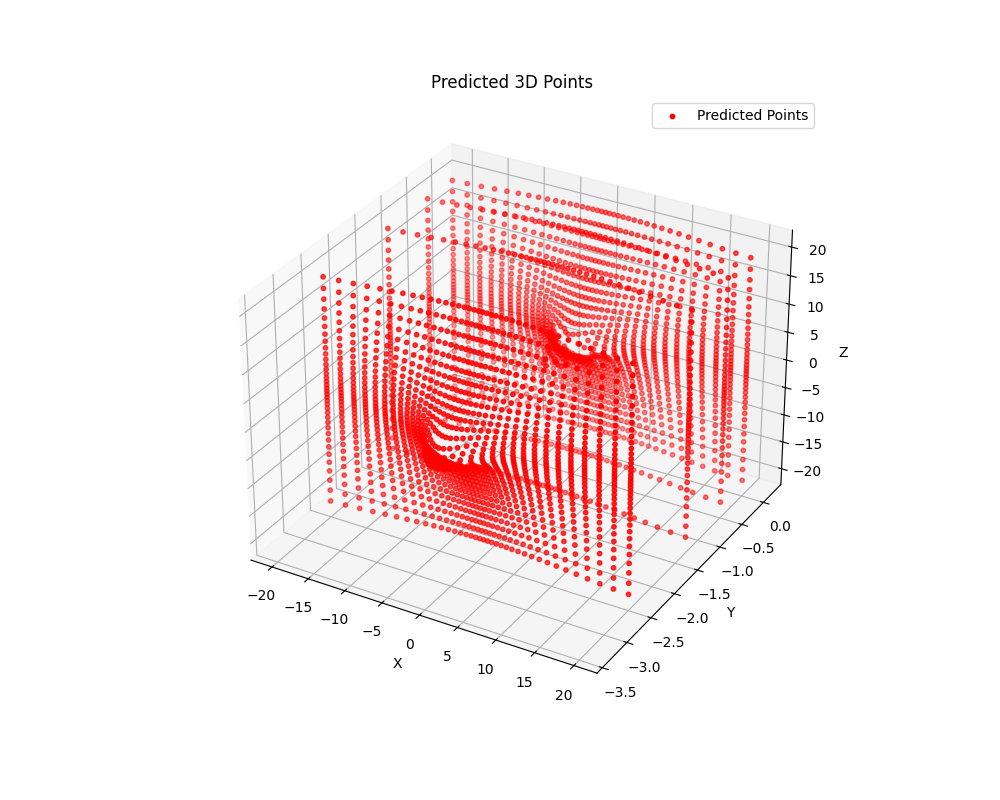

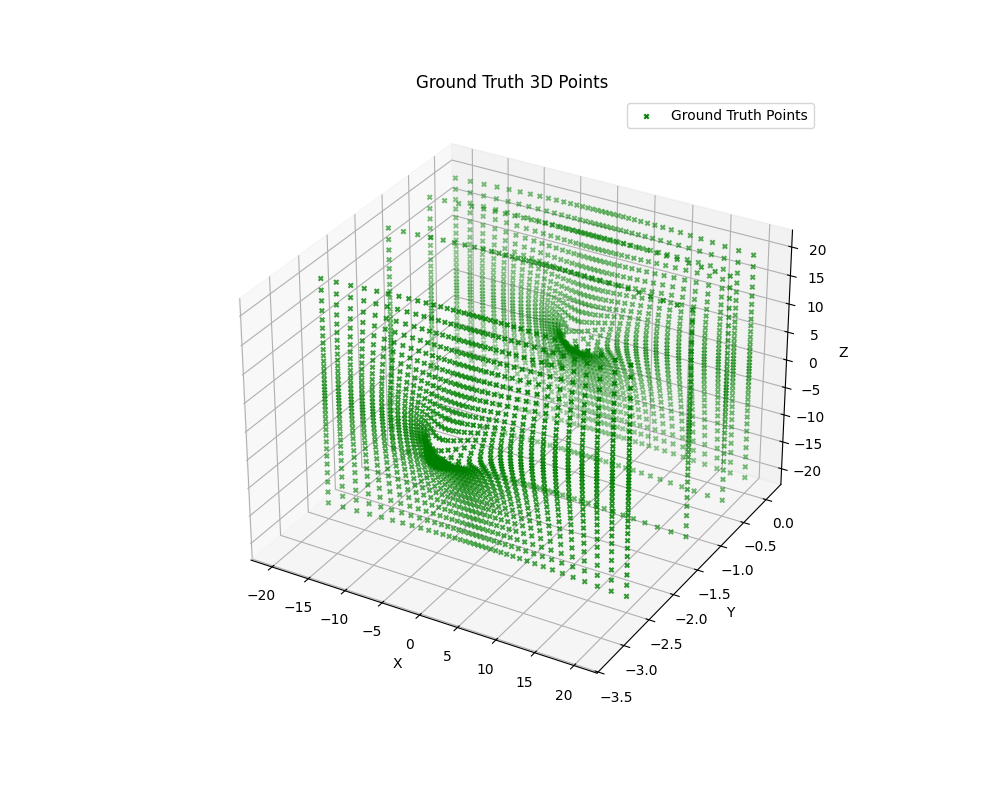

In [5]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_points_sequence_3d_separate(init_coord_data, gt_data, predicted_displacements, connect_points=True):
    """
    Plots two separate 3D figures: one for ground truth points and one for predicted points.

    Args:
        init_coord_data (numpy.ndarray): Initial positions of shape (N, 3).
        gt_data (numpy.ndarray): Ground truth displacements of shape (N, 3).
        predicted_displacements (numpy.ndarray): Predicted displacements of shape (N, 3).
        connect_points (bool): Whether to draw lines connecting successive points.
    """
    # Compute final positions
    gt_points = init_coord_data + gt_data
    predicted_points = init_coord_data + predicted_displacements

    # ---------- Ground Truth Figure ----------
    fig_gt = plt.figure(figsize=(10, 8))
    ax_gt = fig_gt.add_subplot(111, projection='3d')
    ax_gt.scatter(gt_points[:, 0], gt_points[:, 1], gt_points[:, 2],
                  color='green', label='Ground Truth Points', marker='x', s=10)

    if connect_points:
        for i in range(len(gt_points) - 1):
            ax_gt.plot([gt_points[i, 0], gt_points[i + 1, 0]],
                       [gt_points[i, 1], gt_points[i + 1, 1]],
                       [gt_points[i, 2], gt_points[i + 1, 2]], 'g-', alpha=0.5)

    ax_gt.set_title('Ground Truth 3D Points')
    ax_gt.set_xlabel('X')
    ax_gt.set_ylabel('Y')
    ax_gt.set_zlabel('Z')
    ax_gt.legend()
    plt.grid(True)

    # ---------- Predicted Points Figure ----------
    fig_pred = plt.figure(figsize=(10, 8))
    ax_pred = fig_pred.add_subplot(111, projection='3d')
    ax_pred.scatter(predicted_points[:, 0], predicted_points[:, 1], predicted_points[:, 2],
                    color='red', label='Predicted Points', marker='o', s=10)

    if connect_points:
        for i in range(len(predicted_points) - 1):
            ax_pred.plot([predicted_points[i, 0], predicted_points[i + 1, 0]],
                         [predicted_points[i, 1], predicted_points[i + 1, 1]],
                         [predicted_points[i, 2], predicted_points[i + 1, 2]], 'r-', alpha=0.5)

    ax_pred.set_title('Predicted 3D Points')
    ax_pred.set_xlabel('X')
    ax_pred.set_ylabel('Y')
    ax_pred.set_zlabel('Z')
    ax_pred.legend()
    plt.grid(True)

    # Show both figures
    plt.show()



# Example usage for a given sample index
# Assuming `init_coord_data`, `gt_data`, and `predicted_displacements` are NumPy arrays of shape (N, 2)
# For example:
images, targets, init_data = test_loader.dataset[1]
images = images.to(device)
images = images[None, :, :]
attention_mask = create_attention_mask(images).to(device)
init_data = init_data.numpy().reshape(-1,3)
targets = targets.numpy().reshape(-1,3)
predicted_displacements = trained_model(images,None)
predicted_displacements = denormalize_targets(predicted_displacements,norm_values)
predicted_displacements = predicted_displacements.cpu().detach().numpy()
predicted_displacements = predicted_displacements.reshape(-1,3)
#import pdb; pdb.set_trace()
# Call the function to plot the points for a sample
plot_points_sequence_3d_separate(init_data, targets, predicted_displacements,connect_points=False)



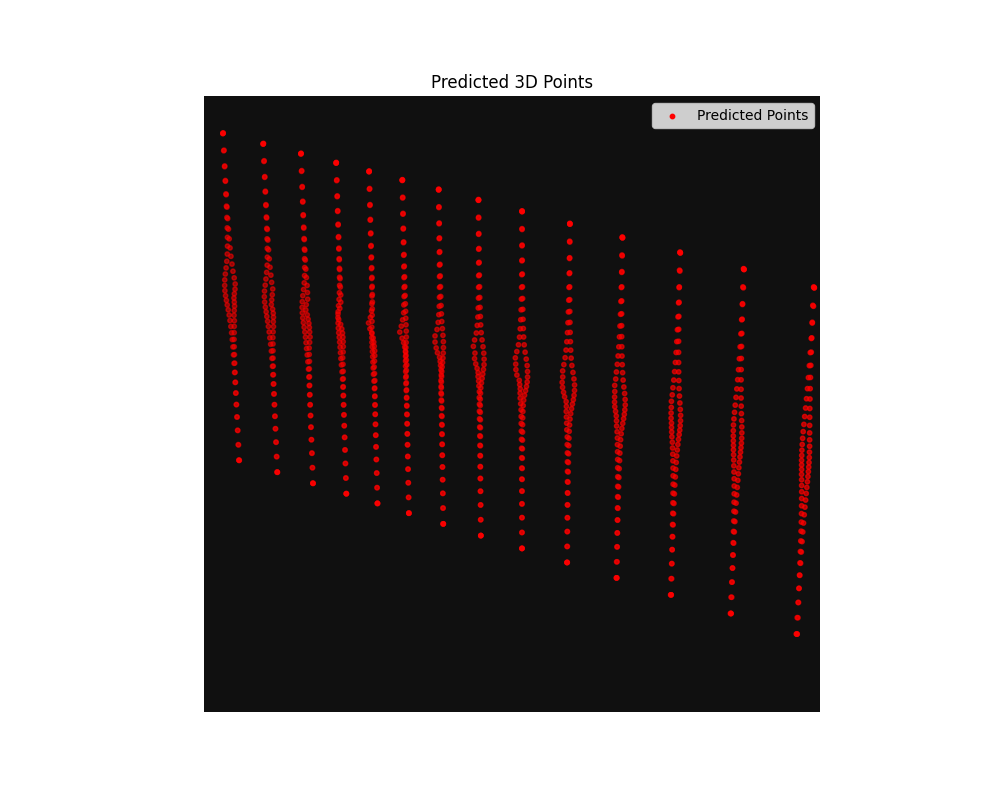

In [6]:
def plot_image_tensor(image_tensor):
    """
    Takes a PyTorch tensor representing image data and plots the image.

    Args:
        image_tensor (torch.Tensor): A tensor representing image data with shape 
                                     (batch_size, channels, height, width).
    """
    # Check if the tensor is a single image or a batch
    if image_tensor.ndimension() == 4:
        # If batch size is greater than 1, let's plot the first image
        image_tensor = image_tensor[0]  # Take the first image in the batch
    
    # Convert the tensor to a NumPy array and move channels to last dimension (for plotting)
    image_array = image_tensor.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    #image_array[:, :, 1] = 1
    # If the image is grayscale (single channel), it will have only one channel
    if image_array.shape[2] == 1:
        image_array = image_array[:, :, 0]  # Convert to 2D for grayscale images
    
    # Plot the image
    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
    plt.axis('off')  # Hide axes
    plt.show()

plot_image_tensor(images[:,:,:].cpu())

In [7]:
images.shape

torch.Size([1, 380, 6])